#### Load required libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
from sklearn.preprocessing import scale
from tpot import TPOTClassifier
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13

#### Define helper functions

In [2]:
def read_data(file_path):
    data = pd.read_csv(file_path,header = 0)
    data["date"] = pd.to_datetime(data["date"])
    data["year"] = data["date"].dt.year
    data["month"] = data["date"].dt.month
    data["day"] = data["date"].dt.day
    data["hour"] = data["date"].dt.hour
    data["minute"] = data["date"].dt.minute
    data["second"] = data["date"].dt.second
    data['weekday'] = data[['date']].apply(lambda x: dt.datetime.strftime(x['date'], '%A'), axis=1)
    return data

def plot_signal(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%A, %b %d'))
    ax.set_xlim([min(x) , max(x)])
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.grid(True)

#### Read training and testing dataset

In [3]:
tr_data = read_data("datatraining.txt")
ts_one_data = read_data("datatest.txt")
ts_two_data = read_data("datatest2.txt")

#### Plot signal values over time from training set

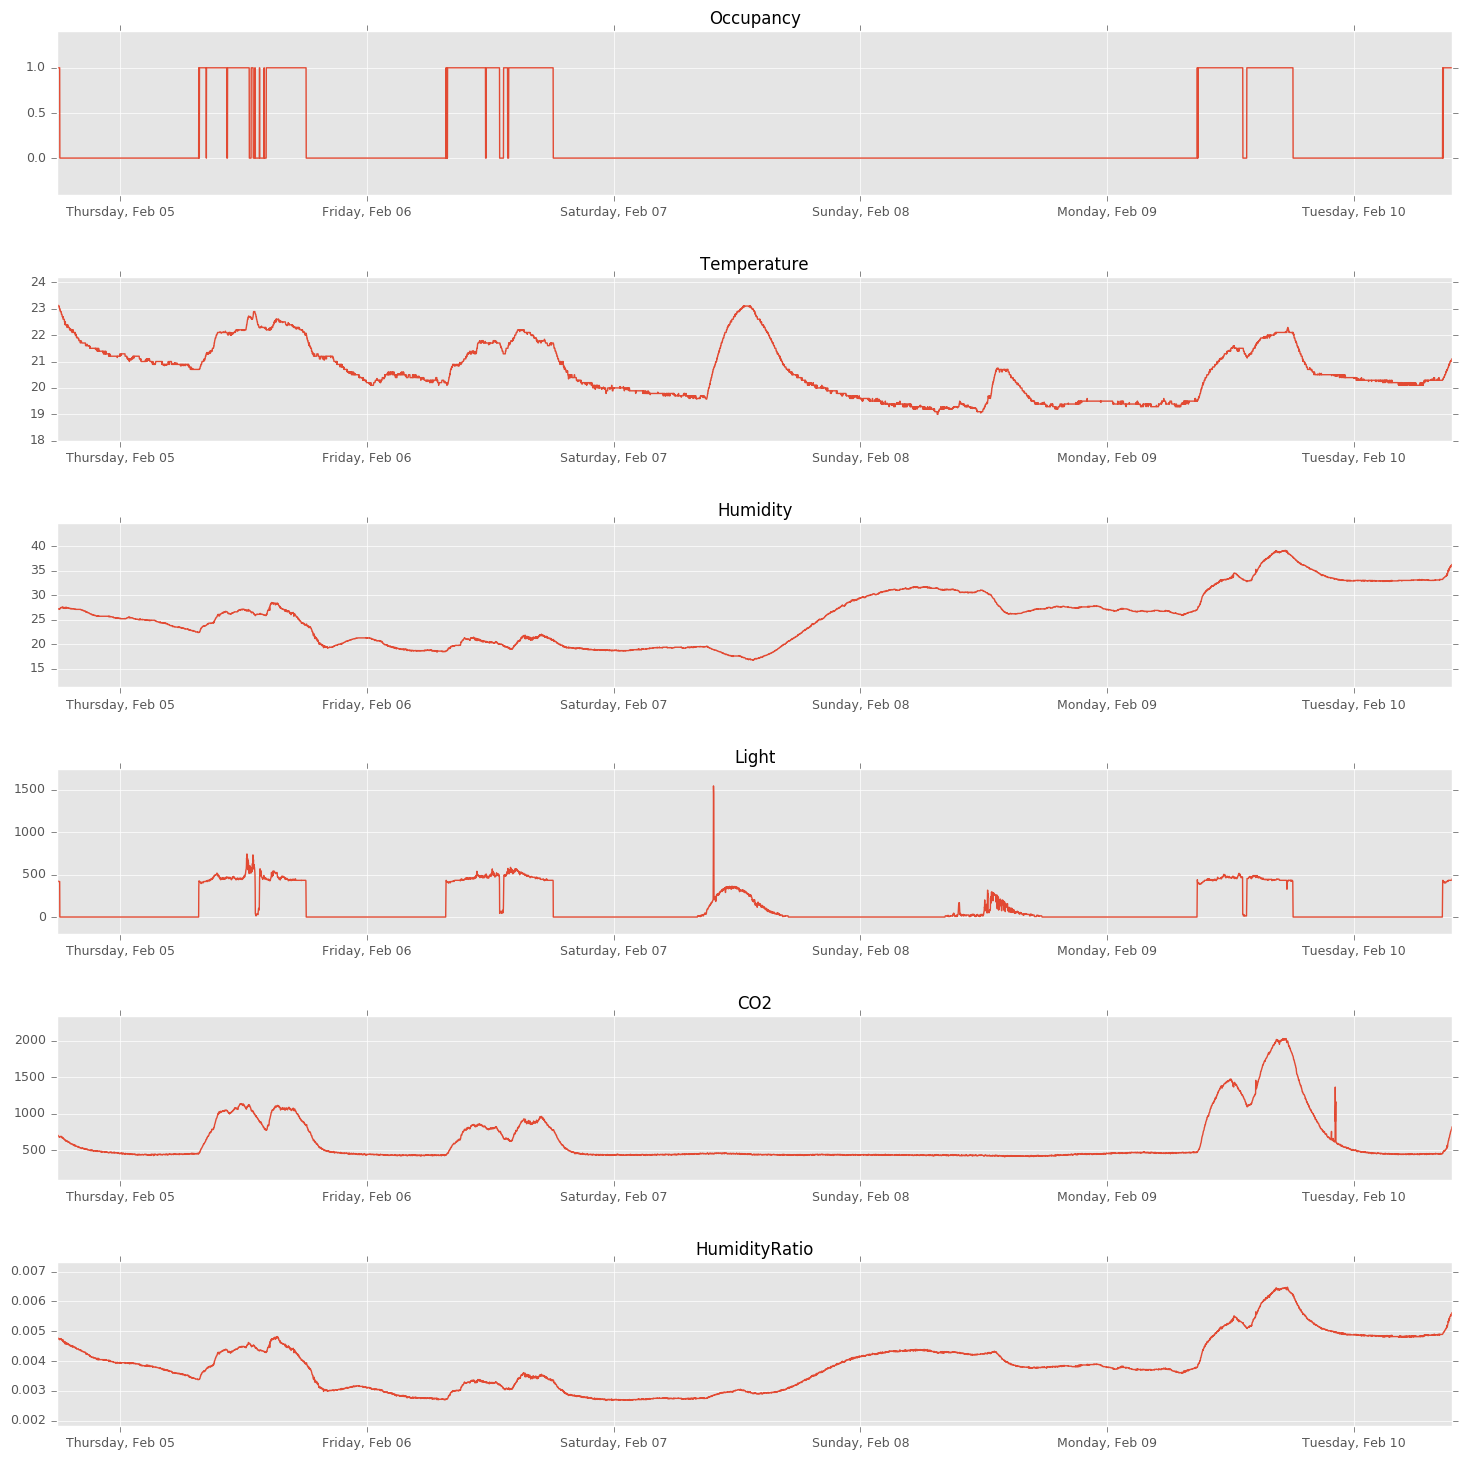

In [4]:
subset_features = tr_data[["Occupancy","Temperature","Humidity","Light","CO2","HumidityRatio"]]

fig, axs = plt.subplots(nrows = len(subset_features.columns.values), figsize=(18, 18))
for i in range(0, len(subset_features.columns.values)):
    plot_signal(axs[i],tr_data["date"], 
                subset_features[subset_features.columns.values[i]],subset_features.columns.values[i])
plt.subplots_adjust(hspace=0.5)
plt.show()

#### Scale and average features by Occupancy for plotting 

/home/aqibsaeed/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


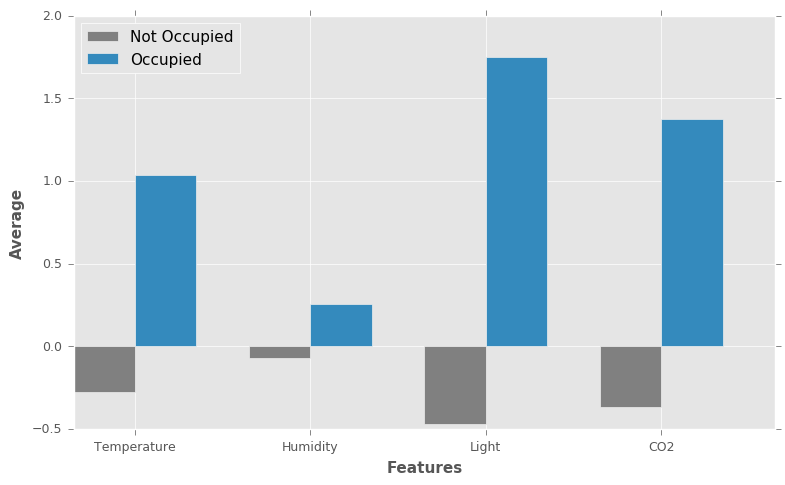

In [5]:
scaled_data =  tr_data[["Temperature","Humidity","Light","CO2","HumidityRatio","Occupancy"]]

scaled_data.loc[:,"Temperature"] = scale(scaled_data["Temperature"])
scaled_data.loc[:,"Humidity"] = scale(scaled_data["Humidity"])
scaled_data.loc[:,"Light"] = scale(scaled_data["Light"])
scaled_data.loc[:,"CO2"] = scale(scaled_data["CO2"])


summary_occupancy = scaled_data[["Temperature","Humidity","Light","CO2","HumidityRatio","Occupancy"]].\
        groupby(["Occupancy"],as_index = False).mean()
    
n_groups = 4
fig, ax = plt.subplots(figsize = (8,5))
index = np.arange(n_groups)
bar_width = 0.35
    
rects_no = plt.bar(index,np.asarray(summary_occupancy[["Temperature","Humidity","Light","CO2"]])[0], 
                 bar_width,
                 color="grey",
                 label="Not Occupied")
 
    
rects_o = plt.bar(index + bar_width,np.asarray(summary_occupancy[["Temperature","Humidity","Light","CO2"]])[1], 
                 bar_width,
                 label="Occupied")

plt.xlabel("Features")
plt.ylabel("Average")
plt.xticks(index + bar_width, ("Temperature", "Humidity","Light", "CO2")) 
plt.legend(loc = "upper left")
 
plt.tight_layout()
plt.show()

### Automate Machine Learning using TPOT Library
#### Select features and labels from training and testing datasets

1. Do the optimization for finding out best model 
2. Evaluate the performance on test set one and test set two
3. Export the python code of best found Machine Learning pipeline

In [4]:
tr_features = tr_data[["Temperature","Humidity","Light","CO2","HumidityRatio"]]
tr_labels = tr_data["Occupancy"]

ts_one_features = ts_one_data[["Temperature","Humidity","Light","CO2","HumidityRatio"]]
ts_one_labels = ts_one_data["Occupancy"]

ts_two_features = ts_two_data[["Temperature","Humidity","Light","CO2","HumidityRatio"]]
ts_two_labels = ts_two_data["Occupancy"]

In [8]:
tpot = TPOTClassifier(generations = 1 , population_size = 5, verbosity = 2)
tpot.fit(tr_features, tr_labels)

print("Test set one:")
print(tpot.score(ts_one_features, ts_one_labels))

print("Test set two:")
print(tpot.score(ts_two_features, ts_two_labels))

tpot.export('od_pipeline.py')

Optimization Progress:  50%|█████     | 5/10 [00:00<00:58, 11.73s/pipeline]

Generation 1 - Current best internal CV score: 0.990001717535



Best pipeline: LogisticRegression(input_matrix, 0.42999999999999999, 16, True)
Test set one:
0.982213435132
Test set two:
0.993371885115
